# Tutorial1: Generating Gaussian Random Fields
---
This tutorial demonstrates the methods used for generation and vizualization of spatio-temporal Gaussian random fields.

The python wrapper pynoisy [1] is introduced and the parameters defined by the general xy model (inoisy/model_general_xy.c) are plotted. pynoisy is a modified verions of [2] which is used to define general matrices as input parameters to the stochastic partial differential equation (SPDE) solver. The SPDE is solved using HYPRE computing library library [3]. 

References
---

[1] https://github.com/aviadlevis/pynoisy 

[2] https://github.com/AFD-Illinois/inoisy

[3] https://github.com/hypre-space/hypre



In [1]:
%matplotlib notebook
import pynoisy
import numpy as np
import matplotlib.pyplot as plt

Welcome to eht-imaging! v 1.1.1 



<IPython.core.display.Javascript object>


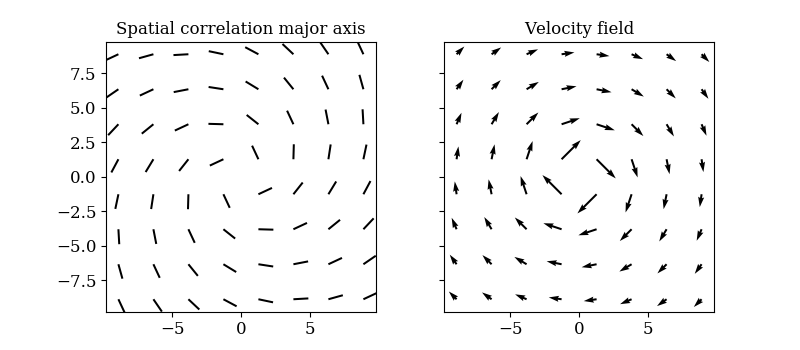

In [2]:
"""
Define diffusion and advection fields and plot the velocity and diffusion tensor principle axis
"""
diffusion = pynoisy.diffusion.general_xy(nx=64, ny=64)
advection = pynoisy.advection.general_xy(nx=64, ny=64)

%matplotlib notebook
fig, ax = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(8,3.5))
diffusion.utils_visualization.major_axis(ax=ax[0])
advection.utils_visualization.velocity_quiver(ax=ax[1])

In [4]:
"""
Run inoisy which solves an anisotropic spatio-temporal diffusion PDE. 
Generate two GRFs with different random source seeds.
"""
solver = pynoisy.forward.HGRFSolver(advection, diffusion, nt=64)
grfs = solver.run(num_samples=2)

<IPython.core.display.Javascript object>


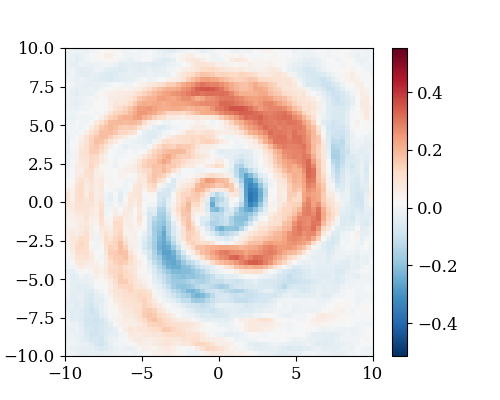

In [5]:
"""
Visualize the first GRF as an animated gif
"""
fig, ax = plt.subplots(figsize=(5,4))
grfs.isel(sample=0).utils_visualization.animate(ax=ax, cmap='RdBu_r')

<IPython.core.display.Javascript object>


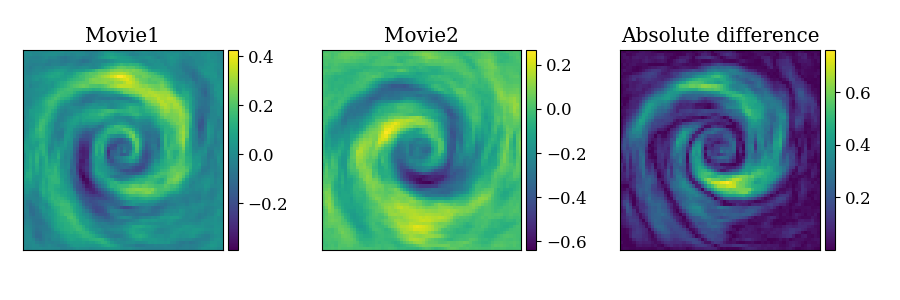

interactive(children=(IntSlider(value=31, description='frame', max=63), Output()), _dom_classes=('widget-inter…

In [6]:
"""
Compare the two GRFs pixels using an interactive slider on a frame by frame basis
"""
pynoisy.visualization.slider_frame_comparison(grfs.isel(sample=0), grfs.isel(sample=1))

In [7]:
"""
Define *new* diffusion and advection fields.
Generate a new GRF with the same random noise source (using the same seed) but different underlying parameters.
"""
diffusion_new = pynoisy.diffusion.general_xy(nx=solver.nx, ny=solver.ny, opening_angle=0.5)
advection_new = pynoisy.advection.general_xy(nx=solver.nx, ny=solver.ny, opening_angle=1.0)
solver.update_diffusion(diffusion_new)
solver.update_advection(advection_new)
grf_new = solver.run()

<IPython.core.display.Javascript object>


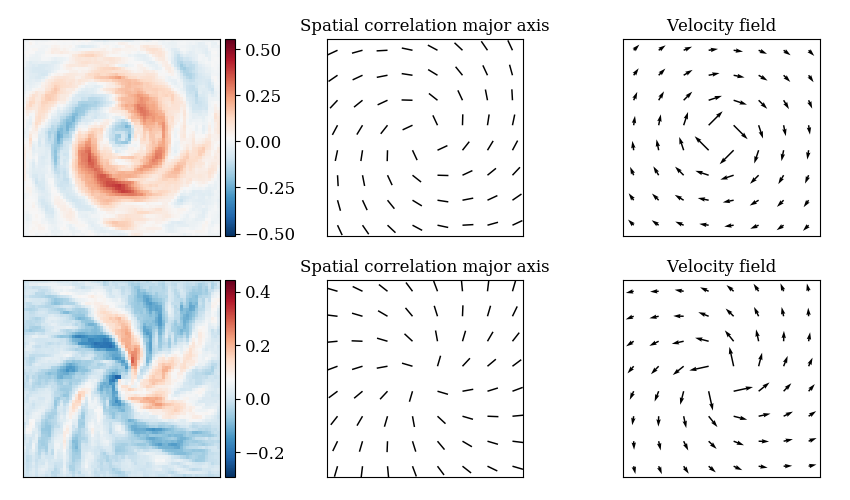

In [8]:
"""
Visualize both GRFs and the underlying parameters using synced animations. 
"""
fig, ax = plt.subplots(2, 3, sharey=True, sharex=True, figsize=(8.5,5))
diffusion.utils_visualization.major_axis(ax=ax[0,1])
advection.utils_visualization.velocity_quiver(ax=ax[0,2])
diffusion_new.utils_visualization.major_axis(ax=ax[1,1])
advection_new.utils_visualization.velocity_quiver(ax=ax[1,2])
plt.tight_layout()
pynoisy.visualization.animate_synced(movie_list=[grfs.isel(sample=0), grf_new], axes=ax[:,0])

<IPython.core.display.Javascript object>


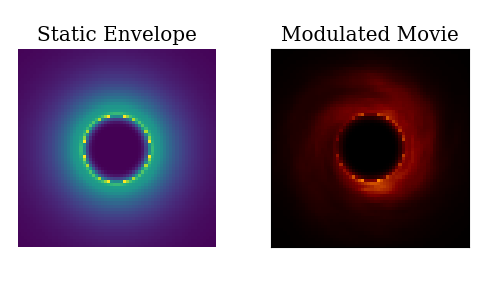

In [9]:
"""
Modulate a static Envelope image with the GRF: Video = Envelope * exp(alpha * GRF)
alpha dictates the strength of the dynamic perturbation (variance of the GRF). 
"""
alpha = 2.0
envelope = pynoisy.envelope.ring(nx=64, ny=64).utils_image.set_fov(grfs.utils_image.fov)
movie = pynoisy.forward.modulate(envelope, grfs.isel(sample=0), alpha)

fig, ax = plt.subplots(1, 2, figsize=(5,3))
envelope.plot(ax=ax[0], add_labels=False, add_colorbar=False)
ax[0].axis('off')
ax[0].set_title('Static Envelope')
ax[1].set_title('Modulated Movie')
ax[0].set_aspect('equal')
plt.tight_layout()
movie.utils_visualization.animate(ax=ax[1], add_ticks=False, add_colorbar=False, cmap='afmhot')